# Deep learning and embeddings

Now that we have our dataset and some understanding of the model, let's discuss how to actually train something useful. Let's talk about embeddings!

Some of you have probably heard the term "foundation model." This is a deep learning model, usually large and trained on enormous amounts of data, that doesn't have any "practical" task other than learning the patterns in the dataset. These patterns can be so complex that humans couldn't realistically come up with them on their own. Models like that will then take, as input, a sequence (in our case, a protein sequence) and output a vector of numbers called an `embedding`. This vector will be packed with information about patterns present in the given sequence. It's not something humans can read, but secondary ML models can effectively use this vector and accurately predict values they're trained to predict.

In our case, we have our dataset of temperatures and sequences. As we saw in the previous notebook, we didn't have an easy way to train an XGBoost model that would accurately predict the temperature. In this notebook, we will use Ginkgo's pretrained foundation model called [AA-0](https://www.ginkgobioworks.com/2024/09/17/aa-0-protein-llm-technical-review/) to calculate embeddings for our dataset. We will access this model through our web server (API), allowing you to produce training embeddings without access to GPUs or any specialized hardware.

We will use a package called [ginkgo-ai-client](https://github.com/ginkgobioworks/ginkgo-ai-client/tree/main) which makes it easier to access the API. You will also need an account and key from the [Ginkgo model API](https://models.ginkgobioworks.ai/), which you can find in the `Settings` tab in the model UI. Save it to an environment variable called `GINKGOAI_API_KEY` in a file somewhere (like a .env file in your home folder) and we'll load it using `dotenv`.

Example .env file:
```
GINKGOAI_API_KEY=abcabc
```

In [1]:
import dotenv
import os
env_file = "../.env"  # Change this to your .env file location
assert os.path.exists(env_file), "Please create a .env file with your API key"

dotenv.load_dotenv(env_file, override=True)
assert os.getenv("GINKGOAI_API_KEY") is not None, "Please set your API key in the .env file"


Now, let's run an example prediction using Ginkgo's AA-0 model.

In [2]:
from ginkgo_ai_client import (
    GinkgoAIClient,
    MaskedInferenceQuery,
    MeanEmbeddingQuery,
)

client = GinkgoAIClient()

aa0_model = "ginkgo-aa0-650M"

queries = [
    MeanEmbeddingQuery(sequence="MLYLRRL", model=aa0_model),
    MeanEmbeddingQuery(sequence="MLYRRL", model=aa0_model),
    MeanEmbeddingQuery(sequence="MLYLLRRL", model=aa0_model),
]
responses = client.send_batch_request(queries)

In [3]:
embeddings = [p.embedding for p in responses]
embeddings[0][:20]

[-0.2410384565591812,
 0.1118989661335945,
 -0.3930843770503998,
 -0.2676232159137726,
 -0.04871775582432747,
 -0.1515751630067825,
 0.02308034151792526,
 0.02247585915029049,
 -0.03512640669941902,
 0.02068932540714741,
 -0.09789848327636719,
 -0.09903421998023987,
 0.1008697748184204,
 -0.1763597875833511,
 -0.610081672668457,
 0.07856658846139908,
 -0.2632047235965729,
 0.0639657974243164,
 -0.1556835174560547,
 -0.1417402476072311]

In [4]:
len(embeddings[0])

1280

As you can see, each sequence, even our example nonsensical one, is a list of 1280 numbers. These numbers are completely inscrutable for humans but, hopefully, packed with information for machines.

In [5]:
import pandas as pd
import numpy as np

test_df = pd.read_csv('../data/test_df.csv')
train_df = pd.read_csv('../data/train_df.csv')

Let's create a tabular dataset for XGBoost. It will be a dataframe with `1281` columns: `1280` for the embedding size and one for the temperature label.

In [6]:
def get_embeddings(df):
    queries = [
        MeanEmbeddingQuery(sequence=seq, model=aa0_model) for seq in df["sequence"]
    ]
    responses = client.send_batch_request(queries)
    embeddings = [p.embedding for p in responses]

    embedding_names = [f"e-{i}" for i, emb in enumerate(embeddings[0])]
    embeddings_df = pd.DataFrame(np.array(embeddings), columns=embedding_names)
    embeddings_df["temperature"] = list(df["temperature"])
    return embeddings_df

Since the embedding calculation is a long and expensive process, we should save the results and avoid recalculation unless it's necessary. We'll save the results to CSV files and reuse them if they're already present.

In [7]:
# Takes approximately 3-4 minutes

if not os.path.exists("../data/embeddings_train.csv"):
    train_embeddings_df = get_embeddings(train_df)
    train_embeddings_df.to_csv("../data/embeddings_train.csv")

    test_embeddings_df = get_embeddings(test_df)
    test_embeddings_df.to_csv("../data/embeddings_test.csv")
else:
    train_embeddings_df = pd.read_csv("../data/embeddings_train.csv")
    test_embeddings_df = pd.read_csv("../data/embeddings_test.csv")

In [8]:
train_embeddings_df["temperature"] = list(train_df["temperature"])
test_embeddings_df["temperature"] = list(test_df["temperature"])
train_embeddings_df.head()

,Unnamed: 0,e-0,e-1,e-2,e-3,e-4,e-5,e-6,e-7,e-8,...,e-1271,e-1272,e-1273,e-1274,e-1275,e-1276,e-1277,e-1278,e-1279,temperature
0,0,0.101593,0.095818,-0.223492,0.083811,0.034447,0.022522,-0.005927,-0.100536,-0.072165,...,-0.064838,-0.032989,-0.070042,-0.020074,-0.025528,0.094053,-0.044689,0.010913,0.058952,29.333333
1,1,-0.066381,0.163949,-0.221450,0.000772,-0.065560,-0.126023,0.067668,-0.076334,-0.066342,...,-0.154788,-0.048650,-0.086241,-0.092503,0.036259,-0.028660,0.028472,0.001052,-0.006734,80.000000
2,2,-0.049085,0.026295,-0.169340,0.072944,0.029128,-0.121401,-0.080230,0.022613,-0.054610,...,-0.128536,-0.085520,-0.055900,0.007329,-0.025570,0.098627,0.037857,0.138432,0.080265,30.000000
3,3,0.067761,-0.038003,-0.175906,-0.015694,0.010992,-0.029483,-0.035979,-0.047662,-0.102450,...,-0.174706,-0.065998,0.031485,-0.091745,-0.004813,0.035645,0.046048,0.038570,0.049071,37.000000
4,4,0.008460,-0.087591,-0.195453,0.039576,-0.065107,-0.136874,-0.159391,0.130665,-0.051237,...,-0.259007,-0.036351,0.115923,-0.074272,-0.073683,0.026996,0.017617,0.019810,0.005016,18.750000


Now that we have our dataset, we'll train our XGBoost model. All `1280` columns are features, and `temperature` is what we want to predict.

The model will be similar to the one we used in the previous notebook. Since we are now trying to train a real model, let's set `ntrees` and `max_depth`. This will increase training time, but XGBoost is very efficient and it won't take long to train even with these configurations.

`ntrees`, `max_depth`, and `learning_rate` are called *hyperparameters*: configurations of our model that aren't directly related to data. It's good practice to experiment with several values and see which one produces the best results.

In [9]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Specify model hyperparameters
model = XGBRegressor(
    random_state=42
)

X_train = train_embeddings_df[[col for col in train_embeddings_df if col.startswith("e")]]  
y_train = train_embeddings_df['temperature']
X_test = test_embeddings_df[[col for col in test_embeddings_df if col.startswith("e")]]
y_test = test_embeddings_df['temperature']

# Train the model
model.fit(X_train, y_train)

# Make predictions and evaluate
train_pred = model.predict(X_train) 
test_pred = model.predict(X_test)

print("Train MSE:", mean_squared_error(y_train, train_pred))  
print("Test MSE:", mean_squared_error(y_test, test_pred))
print("Train R2:", r2_score(y_train, train_pred))
print("Test R2:", r2_score(y_test, test_pred))

# Calculate Pearson correlation
pearson_corr = np.corrcoef(y_test, test_pred)[0,1]
print(f"\nPearson correlation on test set: {pearson_corr:.4f}")

Train MSE: 0.0001579928964292652
Test MSE: 261.3076073859842
Train R2: 0.9999998029078143
Test R2: 0.6727257859435755

Pearson correlation on test set: 0.8216


It's a good idea to examine your predictions. Let's draw a scatter plot comparing the actual values vs. the model's predictions.

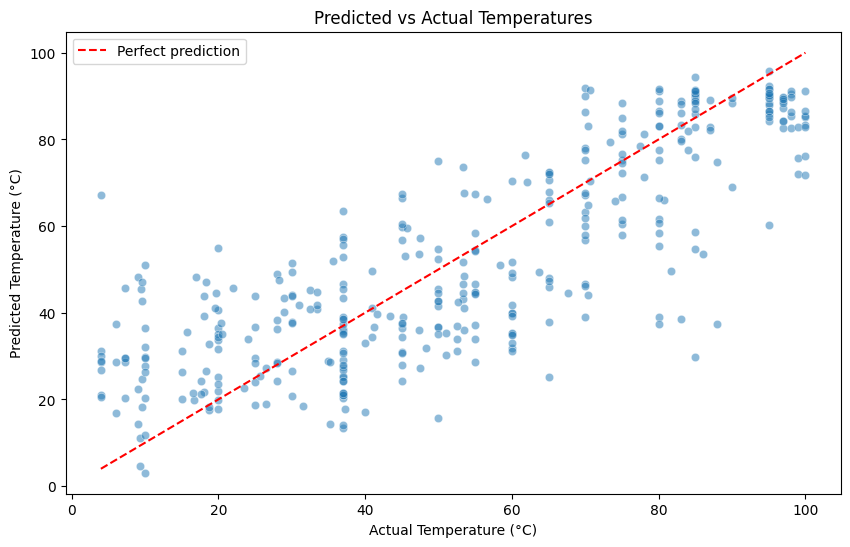

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=test_pred.flatten(), alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect prediction')
plt.xlabel('Actual Temperature (°C)')
plt.ylabel('Predicted Temperature (°C)')
plt.title('Predicted vs Actual Temperatures')
plt.legend()
plt.show()

Nice! This result looks much better than our toy model from before. While there is space for improvement, it's already a useful model. Let's save it to a file.

In [11]:
# Save model to file
import joblib
model_path = "../data/model.pkl"
joblib.dump(model, model_path)
print(f"Model saved to: {model_path}")

Model saved to: ../data/model.pkl


Now, let's load our model and predict the temperature for an example protein, GFP.

In [12]:
# Load the saved model
loaded_model = joblib.load(model_path)

# Get GFP sequence embedding
gfp_sequence = "MSKGEELFTGVVPILVELDGDVNGHKFSVSGEGEGDATYGKLTLKFICTTGKLPVPWPTLVTTFSYGVQCFSRYPDHMKQHDFFKSAMPEGYVQERTIFFKDDGNYKTRAEVKFEGDTLVNRIELKGIDFKEDGNILGHKLEYNYNSHNVYIMADKQKNGIKVNFKIRHNIEDGSVQLADHYQQNTPIGDGPVLLPDNHYLSTQSALSKDPNEKRDHMVLLEFVTAAGITHGMDELYK"

query = MeanEmbeddingQuery(sequence=gfp_sequence, model=aa0_model)
response = client.send_request(query)
gfp_embedding = response.embedding
# Convert the embedding to a DataFrame for prediction
gfp_embedding_df = pd.DataFrame([gfp_embedding], columns=[f"e-{i}" for i in range(len(gfp_embedding))])

# Make prediction
gfp_pred = loaded_model.predict(gfp_embedding_df)[0]
print(f"\nPredicted melting temperature for GFP: {gfp_pred:.2f}°C")


Predicted melting temperature for GFP: 45.44°C


## Final thoughts

Our model predicts that GFP has a high melting temperature. There is evidence supporting this, as GFP is known to be very heat stable, with a [melting point around 83°C](https://doi.org/10.1016/S0040-6031(03)00397-6). This melting point is significantly higher than the optimal growth temperature of its host, the [water jellyfish](https://en.wikipedia.org/wiki/Aequorea_victoria).

Due to how this dataset was constructed, it's possible that our model actually learned to predict patterns related to species rather than temperature. Such considerations are always important when training functional ML models. I strongly recommend using this model approach with another dataset and being mindful of the patterns that models can pick up, which may not always align with the intended measurements.

There's definitely room for improvement, most likely in data quality and training set size. It's very important to provide ML models with accurate and well-prepared datasets. [Ginkgo Datapoints](https://www.ginkgobioworks.com/datapoints/) is a great resource for such dataset!

## Excersises and follow-ups

I strongly encourage everyone to modify this tutorial and experiment with different things. Here are few ideas:

* Train different regression models instead of XGBoost, like logistic regression.
* Find other regression datasets and try to predict different properties, such as pH stability or binding affinity.
* Try to train a classifier model in a similar way.

## Further reading

I hope you enjoyed this short, functional tour on how to leverage deep learning foundation models (and our API!) to solve applied scientific problems. If you want to learn more about general machine learning and deep learning, I recommend the following materials:

* [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow: Concepts, Tools, and Techniques to Build Intelligent Systems](https://www.amazon.com/Hands-Machine-Learning-Scikit-Learn-TensorFlow/dp/1098125975) by Aurélien Géron
    * This book is an all-time classic. It builds solid foundations for both classical machine learning and deep learning. It uses TensorFlow for the deep learning part, which is less popular in scientific ML (PyTorch is the king here), but the concepts are very easy to transfer.

* [FastAI](https://course.fast.ai/)
    * FastAI is an amazing video course and community. It's focused on the very practical use of deep learning and has you train a functional deep learning model almost immediately. It digs deeper into theory and important concepts later on.

* [Kaggle](https://www.kaggle.com/)
    * Kaggle, which is also the source of our dataset here, is a great resource to practice what you've learned. Each competition will have a prepared dataset and a clear goal. There's also a very strong community of people who share their work and thinking process through well-written notebooks.

* 3blue1brown made fantastic series of [videos](https://www.youtube.com/watch?v=aircAruvnKk) about deep learning under the hood.

* Free [Stanford course](https://www.youtube.com/watch?v=jGwO_UgTS7I&list=PLoROMvodv4rMiGQp3WXShtMGgzqpfVfbU) and other materials made by Andrew Ng.

* [Probabilistic Machine Learning: An Introduction](https://probml.github.io/pml-book/book1.html) is a very detailed overview of machine learning.

* [The Hundred-Page Machine Learning Book](https://themlbook.com/) by Andriy Burkov.

    